# Chapter 5: Single Predictor Models

**Building the Foundation for Multiple Regression**

## Goal

Fit **univariate models** to understand each predictor's relationship with divorce rate:

1. **M5.1:** Divorce ~ Age at marriage
2. **M5.2:** Divorce ~ Marriage rate

These establish baselines before we add multiple predictors.

## The Bayesian Workflow

For each model:
1. Specify priors
2. Prior predictive checks
3. Fit with quap
4. Posterior analysis
5. Posterior predictive checks

---

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [35]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Load and Prepare Data

We'll use **standardized** variables for modeling.

In [36]:
# Load data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
waffle_data = pd.read_csv(url, sep=";")

# Standardize variables
divorce = waffle_data['Divorce'].values
marriage = waffle_data['Marriage'].values
age = waffle_data['MedianAgeMarriage'].values

# Standardize: z = (x - mean) / sd
D = (divorce - divorce.mean()) / divorce.std()
M = (marriage - marriage.mean()) / marriage.std()
A = (age - age.mean()) / age.std()

print(f"Sample size: {len(D)}")
print(f"\nStandardized variables (should have mean≈0, std≈1):")
print(f"  D: mean={D.mean():.3f}, std={D.std():.3f}")
print(f"  M: mean={M.mean():.3f}, std={M.std():.3f}")
print(f"  A: mean={A.mean():.3f}, std={A.std():.3f}")

Sample size: 50

Standardized variables (should have mean≈0, std≈1):
  D: mean=-0.000, std=1.000
  M: mean=-0.000, std=1.000
  A: mean=0.000, std=1.000


---

## Model M5.1: Divorce ~ Age at Marriage

### Model Specification

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_A \cdot A_i$$

**Priors:**
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_A \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

### Why These Priors?

**α ~ Normal(0, 0.2):**
- D is standardized, so mean divorce should be near 0
- SD=0.2 means 95% prior probability α is in [-0.4, 0.4]
- That's ±2 standard deviations on the outcome scale

**β ~ Normal(0, 0.5):**
- Both predictors and outcome are standardized
- β represents change in SD of outcome per SD of predictor
- SD=0.5 is mildly regularizing
- 95% prior: β in [-1, 1] (reasonable range)

**σ ~ Exponential(1):**
- Outcome is standardized (sd=1)
- Most variation should be explained by model
- Exponential(1) concentrates mass near 0, allows larger values

### Visualizing the α Prior

Let's check what α ~ Normal(0, 0.2) actually means in both standardized and original scales.

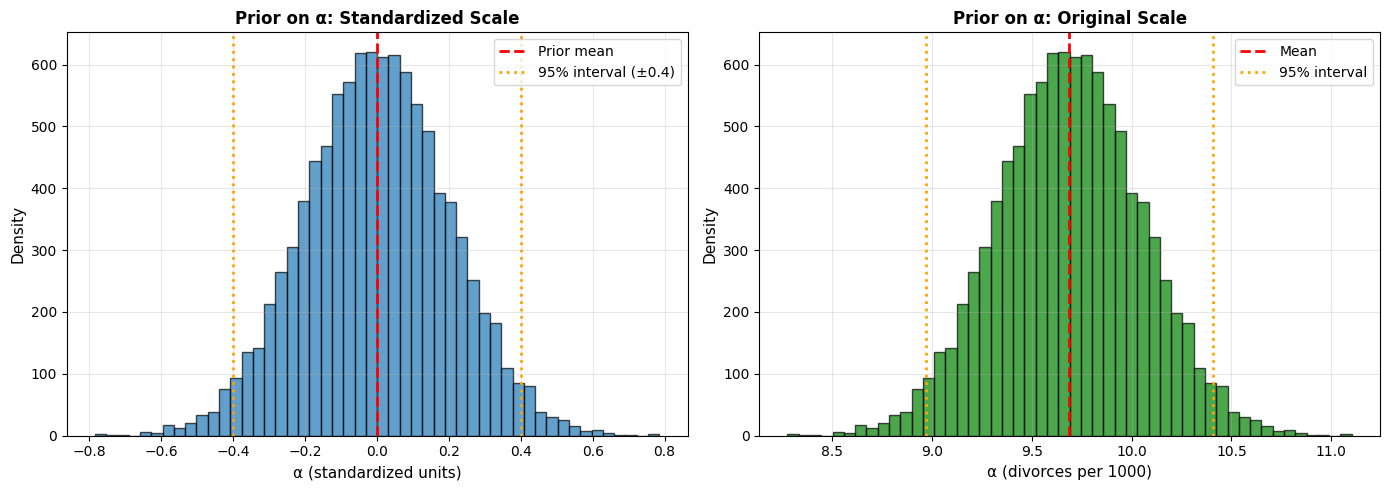

Prior on α ~ Normal(0, 0.2):
Standardized scale:
  Mean: 0.00, SD: 0.20
  95% interval: [-0.39, 0.39]

Original scale (divorces per 1000):
  Mean: 9.69, SD: 0.36
  95% interval: [8.97, 10.41]

Interpretation:
  α represents divorce rate at average age
  Prior says: 95% sure α is within ±0.4 SD of mean
  This is 'weakly informative' - gentle regularization, not restrictive


In [37]:
# Sample intercepts from prior
alpha_samples = np.random.normal(0, 0.2, 10000)

# What does this mean in original units?
alpha_original = alpha_samples * divorce.std() + divorce.mean()

plt.figure(figsize=(14, 5))

# Plot 1: Standardized units
plt.subplot(1, 2, 1)
plt.hist(alpha_samples, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Prior mean')
plt.axvline(-0.4, color='orange', linestyle=':', linewidth=2)
plt.axvline(0.4, color='orange', linestyle=':', linewidth=2, label='95% interval (±0.4)')
plt.xlabel('α (standardized units)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Prior on α: Standardized Scale', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Original units
plt.subplot(1, 2, 2)
plt.hist(alpha_original, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.axvline(divorce.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(divorce.mean() - 0.4*divorce.std(), color='orange', linestyle=':', linewidth=2)
plt.axvline(divorce.mean() + 0.4*divorce.std(), color='orange', linestyle=':', linewidth=2, 
            label='95% interval')
plt.xlabel('α (divorces per 1000)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Prior on α: Original Scale', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prior on α ~ Normal(0, 0.2):")
print("="*70)
print(f"Standardized scale:")
print(f"  Mean: 0.00, SD: 0.20")
print(f"  95% interval: [-0.39, 0.39]")
print(f"\nOriginal scale (divorces per 1000):")
print(f"  Mean: {divorce.mean():.2f}, SD: {0.2*divorce.std():.2f}")
print(f"  95% interval: [{divorce.mean()-0.4*divorce.std():.2f}, {divorce.mean()+0.4*divorce.std():.2f}]")
print(f"\nInterpretation:")
print(f"  α represents divorce rate at average age")
print(f"  Prior says: 95% sure α is within ±0.4 SD of mean")
print(f"  This is 'weakly informative' - gentle regularization, not restrictive")

### Visualizing the β Prior

Now let's understand β ~ Normal(0, 0.5) - the prior on the slope.

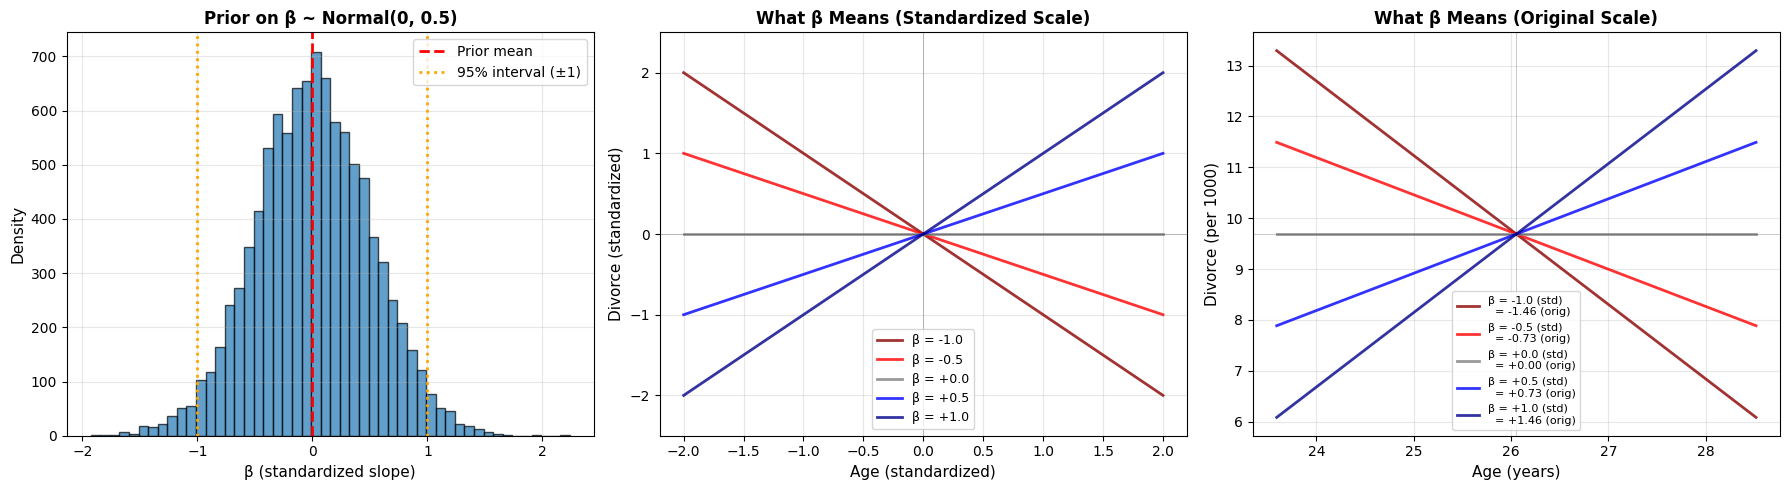

Prior on β ~ Normal(0, 0.5):
Mean: 0.0 (no prior bias toward positive or negative)
SD:   0.5 (weakly informative)

95% interval: [-1.0, 1.0]

Interpretation (standardized units):
  β = 0.5 → 1 SD increase in age → 0.5 SD decrease in divorce
  β = 1.0 → 1 SD increase in age → 1.0 SD decrease in divorce (strong!)

Interpretation (original units):
  1 SD of age = 1.23 years
  1 SD of divorce = 1.80 per 1000
  β = 0.5 (std) → 1.23 year increase → 0.90 decrease in divorce rate
  β = 1.0 (std) → 1.23 year increase → 1.80 decrease in divorce rate

✓ Prior rules out implausibly strong relationships
✓ But allows data to find relationships of any reasonable magnitude


In [38]:
# Sample slopes from prior
beta_samples = np.random.normal(0, 0.5, 10000)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of β
ax = axes[0]
ax.hist(beta_samples, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Prior mean')
ax.axvline(-1, color='orange', linestyle=':', linewidth=2)
ax.axvline(1, color='orange', linestyle=':', linewidth=2, label='95% interval (±1)')
ax.set_xlabel('β (standardized slope)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Prior on β ~ Normal(0, 0.5)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: What different β values mean (standardized scale)
ax = axes[1]
A_range = np.linspace(-2, 2, 100)

# Show specific β values
beta_examples = [-1.0, -0.5, 0, 0.5, 1.0]
colors = ['darkred', 'red', 'gray', 'blue', 'darkblue']
for beta_val, color in zip(beta_examples, colors):
    D_pred = 0 + beta_val * A_range  # α=0 for simplicity
    label = f'β = {beta_val:+.1f}'
    ax.plot(A_range, D_pred, linewidth=2, color=color, label=label, alpha=0.8)

ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Age (standardized)', fontsize=11)
ax.set_ylabel('Divorce (standardized)', fontsize=11)
ax.set_title('What β Means (Standardized Scale)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-2.5, 2.5)

# Plot 3: What β means in original scale
ax = axes[2]
# Convert to original scale
age_range_orig = A_range * age.std() + age.mean()

for beta_val, color in zip(beta_examples, colors):
    # Slope in original units: (change in D per SD of D) / (change in A per SD of A)
    # β_original = β_std * (std_D / std_A)
    slope_orig = beta_val * (divorce.std() / age.std())
    D_pred_orig = divorce.mean() + slope_orig * (age_range_orig - age.mean())
    label = f'β = {beta_val:+.1f} (std)\n  = {slope_orig:+.2f} (orig)'
    ax.plot(age_range_orig, D_pred_orig, linewidth=2, color=color, label=label, alpha=0.8)

ax.axhline(divorce.mean(), color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(age.mean(), color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Age (years)', fontsize=11)
ax.set_ylabel('Divorce (per 1000)', fontsize=11)
ax.set_title('What β Means (Original Scale)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prior on β ~ Normal(0, 0.5):")
print("="*70)
print(f"Mean: 0.0 (no prior bias toward positive or negative)")
print(f"SD:   0.5 (weakly informative)")
print(f"\n95% interval: [{-1.0:.1f}, {1.0:.1f}]")
print(f"\nInterpretation (standardized units):")
print(f"  β = 0.5 → 1 SD increase in age → 0.5 SD decrease in divorce")
print(f"  β = 1.0 → 1 SD increase in age → 1.0 SD decrease in divorce (strong!)")
print(f"\nInterpretation (original units):")
std_age = age.std()
std_divorce = divorce.std()
print(f"  1 SD of age = {std_age:.2f} years")
print(f"  1 SD of divorce = {std_divorce:.2f} per 1000")
print(f"  β = 0.5 (std) → {std_age:.2f} year increase → {0.5*std_divorce:.2f} decrease in divorce rate")
print(f"  β = 1.0 (std) → {std_age:.2f} year increase → {1.0*std_divorce:.2f} decrease in divorce rate")
print(f"\n✓ Prior rules out implausibly strong relationships")
print(f"✓ But allows data to find relationships of any reasonable magnitude")

### Visualizing the σ Prior

Finally, let's understand σ ~ Exponential(1) - the prior on the residual standard deviation.

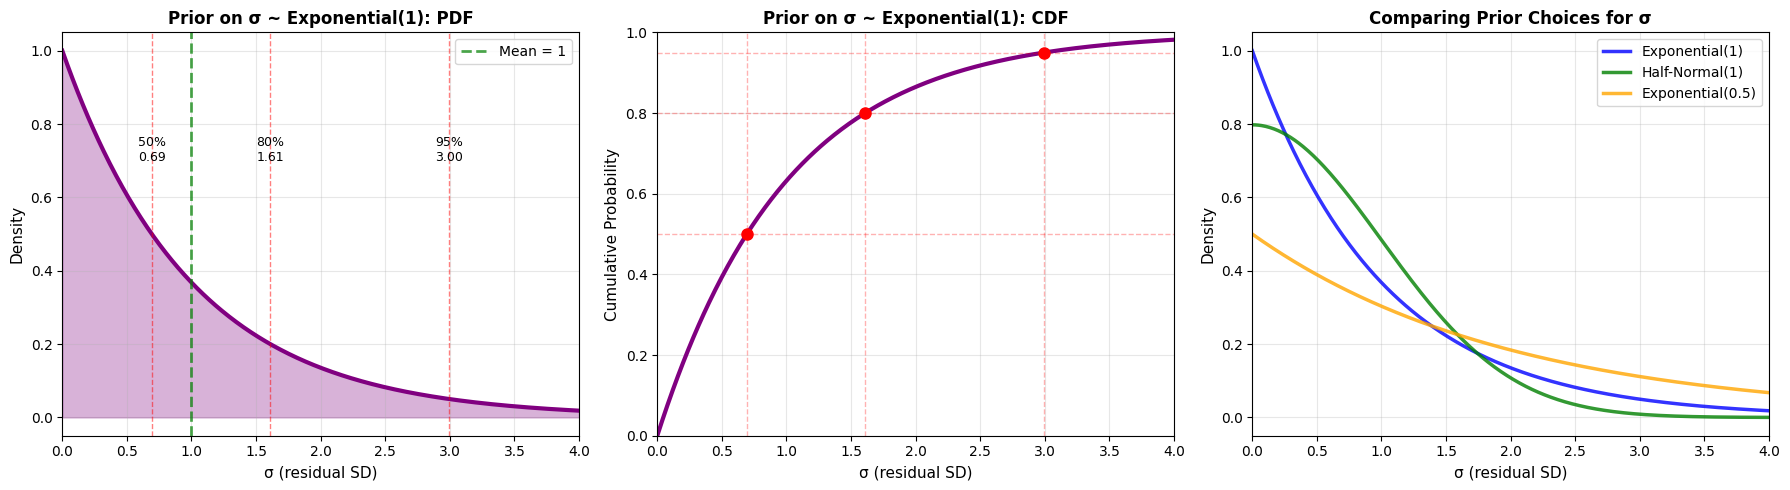

Prior on σ ~ Exponential(1):
Mean:     1.000
Median:   0.693
Mode:     0 (maximum density at origin)

Key Quantiles:
  50% of mass below: 0.693
  80% of mass below: 1.609
  95% of mass below: 2.996
  99% of mass below: 4.605

Interpretation (standardized units):
  D is standardized with SD=1
  σ ~ Exp(1) says: 'I expect residual SD around 1'
  Since D has SD=1, σ=1 means model explains ~0% of variance
  σ=0.8 means model explains ~36% of variance
  σ=0.5 means model explains ~75% of variance

Interpretation (original scale):
  σ_original = σ_std × SD(D) = σ_std × 1.80
  If σ_std = 0.8, then σ_original = 1.44 divorces per 1000

✓ Always positive (σ must be > 0)
✓ Concentrates mass near 0 (prefer models that explain data)
✓ Heavy tail (allows larger σ if model doesn't fit well)
✓ Weakly informative - lets data decide


In [39]:
# Visualize σ ~ Exponential(1)
sigma_vals = np.linspace(0, 4, 500)
pdf_sigma = stats.expon.pdf(sigma_vals, scale=1)  # scale=1 means rate λ=1
cdf_sigma = stats.expon.cdf(sigma_vals, scale=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: PDF
ax = axes[0]
ax.plot(sigma_vals, pdf_sigma, 'purple', linewidth=3)
ax.fill_between(sigma_vals, pdf_sigma, alpha=0.3, color='purple')

# Mark key quantiles
quantiles = [0.5, 0.8, 0.95]
for q in quantiles:
    sigma_q = stats.expon.ppf(q, scale=1)
    ax.axvline(sigma_q, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(sigma_q, pdf_sigma.max() * 0.7, f'{int(q*100)}%\n{sigma_q:.2f}', 
            ha='center', fontsize=9)

# Mark mean
ax.axvline(1, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Mean = 1')

ax.set_xlabel('σ (residual SD)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Prior on σ ~ Exponential(1): PDF', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 4)

# Plot 2: CDF
ax = axes[1]
ax.plot(sigma_vals, cdf_sigma, 'purple', linewidth=3)

for q in quantiles:
    sigma_q = stats.expon.ppf(q, scale=1)
    ax.axhline(q, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(sigma_q, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.plot(sigma_q, q, 'ro', markersize=8)

ax.set_xlabel('σ (residual SD)', fontsize=11)
ax.set_ylabel('Cumulative Probability', fontsize=11)
ax.set_title('Prior on σ ~ Exponential(1): CDF', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)

# Plot 3: Comparison with alternatives
ax = axes[2]
sigma_range = np.linspace(0, 4, 500)

# Exponential(1) - our choice
pdf_exp1 = stats.expon.pdf(sigma_range, scale=1)
ax.plot(sigma_range, pdf_exp1, 'b-', linewidth=2.5, label='Exponential(1)', alpha=0.8)

# Half-Normal(1) - alternative
pdf_hn = stats.halfnorm.pdf(sigma_range, scale=1)
ax.plot(sigma_range, pdf_hn, 'g-', linewidth=2.5, label='Half-Normal(1)', alpha=0.8)

# Exponential(0.5) - weaker prior
pdf_exp05 = stats.expon.pdf(sigma_range, scale=2)
ax.plot(sigma_range, pdf_exp05, 'orange', linewidth=2.5, label='Exponential(0.5)', alpha=0.8)

ax.set_xlabel('σ (residual SD)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Comparing Prior Choices for σ', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 4)

plt.tight_layout()
plt.show()

print("Prior on σ ~ Exponential(1):")
print("="*70)
print(f"Mean:     {stats.expon.mean(scale=1):.3f}")
print(f"Median:   {stats.expon.median(scale=1):.3f}")
print(f"Mode:     0 (maximum density at origin)")
print(f"\nKey Quantiles:")
print(f"  50% of mass below: {stats.expon.ppf(0.5, scale=1):.3f}")
print(f"  80% of mass below: {stats.expon.ppf(0.8, scale=1):.3f}")
print(f"  95% of mass below: {stats.expon.ppf(0.95, scale=1):.3f}")
print(f"  99% of mass below: {stats.expon.ppf(0.99, scale=1):.3f}")

print(f"\nInterpretation (standardized units):")
print(f"  D is standardized with SD=1")
print(f"  σ ~ Exp(1) says: 'I expect residual SD around 1'")
print(f"  Since D has SD=1, σ=1 means model explains ~0% of variance")
print(f"  σ=0.8 means model explains ~36% of variance")
print(f"  σ=0.5 means model explains ~75% of variance")

print(f"\nInterpretation (original scale):")
print(f"  σ_original = σ_std × SD(D) = σ_std × {divorce.std():.2f}")
print(f"  If σ_std = 0.8, then σ_original = {0.8 * divorce.std():.2f} divorces per 1000")

print(f"\n✓ Always positive (σ must be > 0)")
print(f"✓ Concentrates mass near 0 (prefer models that explain data)")
print(f"✓ Heavy tail (allows larger σ if model doesn't fit well)")
print(f"✓ Weakly informative - lets data decide")

In [40]:
# Quick fit of M5.1 for demonstration purposes
# (We'll do the official fit with full explanation later)

def neg_log_posterior_m51(params):
    """M5.1: D ~ α + βA·A"""
    alpha, beta_A, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_A * A
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_A, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

initial_params_m51 = [0.0, 0.0, np.log(1.0)]
param_names_m51 = ['alpha', 'beta_A', 'log_sigma']

m51 = quap(neg_log_posterior_m51, initial_params_m51, param_names_m51)
print("✓ Fitted M5.1 (for demonstration in next sections)")

✓ Fitted M5.1 (for demonstration in next sections)


### Understanding the Log Transformation for σ

**Key Insight:** QUAP finds the posterior of **log(σ)**, not σ directly!

This is because σ must be positive, so we optimize in log-space (unconstrained).

What QUAP Actually Found:
Parameter name: 'log_sigma'
MAP estimate:   -0.2179
Std error:      0.0999

This is a NORMAL distribution on log(σ)

Transformed to σ:
σ (MAP) = exp(-0.2179) = 0.8042


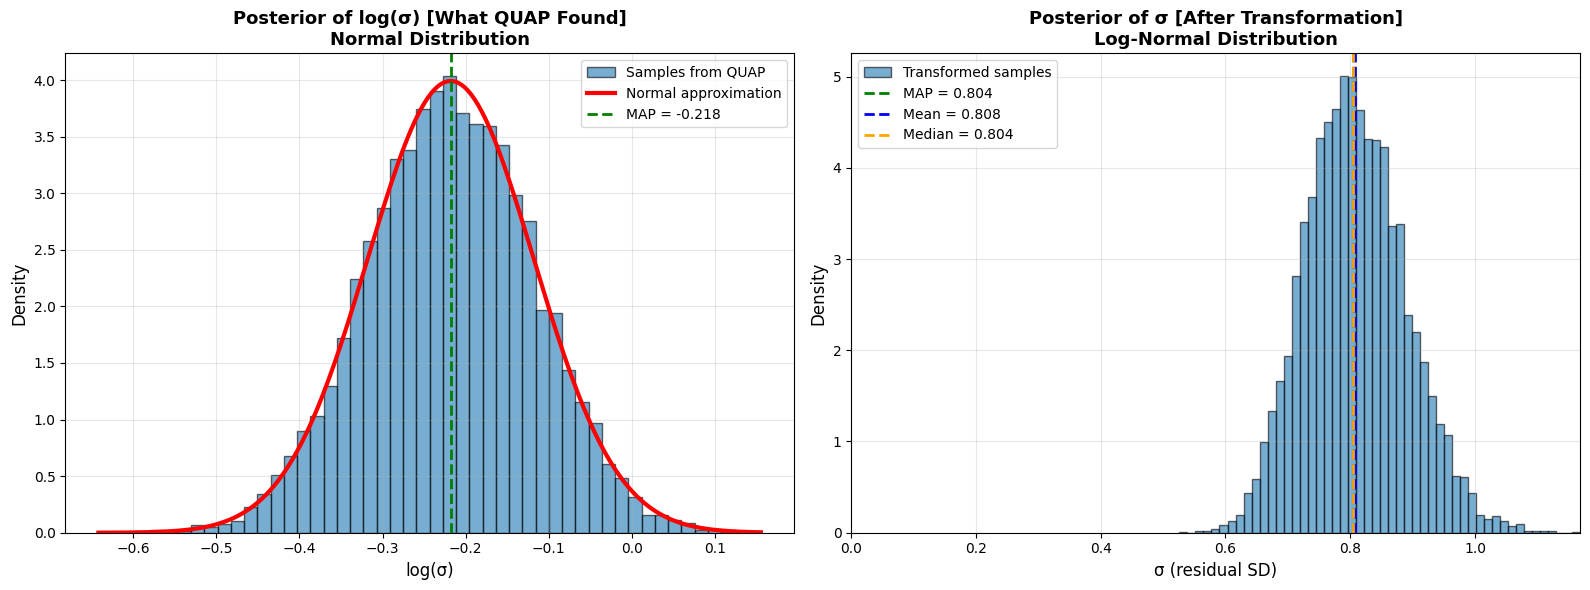


Key Observations:
1. log(σ) ~ Normal(-0.218, 0.100²)
   → Symmetric, can be negative

2. σ = exp(log(σ)) ~ Log-Normal
   → Always positive (as required!)
   → Right-skewed (mode < median < mean)

3. Summary statistics for σ:
   Mode (MAP):  0.8042
   Median:      0.8040
   Mean:        0.8079
   Note: Mean > Median > Mode (log-normal property)

✓ QUAP works in log-space for constrained parameters
✓ This automatically ensures σ > 0
✓ The Jacobian term corrects for the transformation


In [41]:
# Demonstrate: QUAP finds posterior of log(σ), not σ

# After fitting M5.1, let's examine what QUAP actually computed
print("What QUAP Actually Found:")
print("="*70)
print(f"Parameter name: 'log_sigma'")
print(f"MAP estimate:   {m51.coef()['log_sigma']:.4f}")
print(f"Std error:      {m51.vcov().loc['log_sigma', 'log_sigma']**0.5:.4f}")
print(f"\nThis is a NORMAL distribution on log(σ)")

# Transform to get σ
sigma_map = np.exp(m51.coef()['log_sigma'])
print(f"\nTransformed to σ:")
print(f"σ (MAP) = exp({m51.coef()['log_sigma']:.4f}) = {sigma_map:.4f}")

# Sample from posterior
post_samples = m51.sample(n=10000, seed=42)
log_sigma_samples = post_samples['log_sigma'].values
sigma_samples = np.exp(log_sigma_samples)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of log(σ) - This is what QUAP found!
ax = axes[0]
ax.hist(log_sigma_samples, bins=50, density=True, alpha=0.6, edgecolor='black', 
        label='Samples from QUAP')

# Overlay theoretical normal (what QUAP approximates)
log_sigma_mean = m51.coef()['log_sigma']
log_sigma_std = m51.vcov().loc['log_sigma', 'log_sigma']**0.5
x_range = np.linspace(log_sigma_samples.min(), log_sigma_samples.max(), 200)
normal_pdf = stats.norm.pdf(x_range, loc=log_sigma_mean, scale=log_sigma_std)
ax.plot(x_range, normal_pdf, 'r-', linewidth=3, label='Normal approximation')

ax.axvline(log_sigma_mean, color='green', linestyle='--', linewidth=2, 
           label=f'MAP = {log_sigma_mean:.3f}')
ax.set_xlabel('log(σ)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior of log(σ) [What QUAP Found]\nNormal Distribution', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Distribution of σ - This is log-normal!
ax = axes[1]
ax.hist(sigma_samples, bins=50, density=True, alpha=0.6, edgecolor='black',
        label='Transformed samples')

ax.axvline(sigma_map, color='green', linestyle='--', linewidth=2, 
           label=f'MAP = {sigma_map:.3f}')
ax.axvline(sigma_samples.mean(), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean = {sigma_samples.mean():.3f}')
ax.axvline(np.median(sigma_samples), color='orange', linestyle='--', linewidth=2,
           label=f'Median = {np.median(sigma_samples):.3f}')

ax.set_xlabel('σ (residual SD)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior of σ [After Transformation]\nLog-Normal Distribution', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, sigma_samples.max())

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Key Observations:")
print("="*70)
print(f"1. log(σ) ~ Normal({log_sigma_mean:.3f}, {log_sigma_std:.3f}²)")
print(f"   → Symmetric, can be negative")
print(f"\n2. σ = exp(log(σ)) ~ Log-Normal")
print(f"   → Always positive (as required!)")
print(f"   → Right-skewed (mode < median < mean)")
print(f"\n3. Summary statistics for σ:")
print(f"   Mode (MAP):  {sigma_map:.4f}")
print(f"   Median:      {np.median(sigma_samples):.4f}")
print(f"   Mean:        {sigma_samples.mean():.4f}")
print(f"   Note: Mean > Median > Mode (log-normal property)")
print(f"\n✓ QUAP works in log-space for constrained parameters")
print(f"✓ This automatically ensures σ > 0")
print(f"✓ The Jacobian term corrects for the transformation")

### What Happens WITHOUT Log Transformation?

Let's see what breaks when QUAP tries to pass negative σ values.

In [42]:
# Demonstrate what breaks when sigma < 0

print("Testing what happens with different σ values:")
print("="*70)

# Test different sigma values
test_sigmas = [1.0, 0.5, 0.1, 0.0, -0.1, -0.5, -1.0]

for sigma_test in test_sigmas:
    print(f"\nσ = {sigma_test:5.1f}:")
    print("-" * 50)
    
    try:
        # 1. Try to compute likelihood
        mu_test = 0  # Simple case: just look at one data point
        data_point = 1.0
        log_lik = stats.norm.logpdf(data_point, loc=mu_test, scale=sigma_test)
        print(f"  Likelihood: log p(D|σ) = {log_lik:.4f}")
        
        if np.isnan(log_lik) or np.isinf(log_lik):
            print(f"  ⚠️  Result is {log_lik} (problematic!)")
            
    except Exception as e:
        print(f"  ❌ Likelihood ERROR: {type(e).__name__}: {e}")
    
    try:
        # 2. Try to compute prior
        log_prior = stats.expon.logpdf(sigma_test, scale=1)
        print(f"  Prior: log p(σ) = {log_prior:.4f}")
        
        if np.isinf(log_prior):
            print(f"  ⚠️  Prior is -∞ (zero probability!)")
            
    except Exception as e:
        print(f"  ❌ Prior ERROR: {type(e).__name__}: {e}")

print("\n" + "="*70)
print("\nWhat We Learned:")
print("="*70)
print("\n1. σ = 1.0, 0.5, 0.1: Everything works fine ✓")
print("\n2. σ = 0.0:")
print("   • Likelihood → NaN (can't have zero variance!)")
print("   • Prior → -∞ (exponential is undefined at 0)")
print("\n3. σ < 0 (negative):")
print("   • Likelihood → NaN (negative variance is meaningless!)")
print("   • Prior → -∞ (exponential only defined for x ≥ 0)")
print("\n4. Consequences for Optimization:")
print("   • Optimizer crashes with NaN gradients")
print("   • Or gets 'stuck' at boundary (σ = 0)")
print("   • Can't explore negative values")
print("   • Makes optimization problem CONSTRAINED (harder!)")
print("\n✓ Log transformation solves ALL these problems!")

Testing what happens with different σ values:

σ =   1.0:
--------------------------------------------------
  Likelihood: log p(D|σ) = -1.4189
  Prior: log p(σ) = -1.0000

σ =   0.5:
--------------------------------------------------
  Likelihood: log p(D|σ) = -2.2258
  Prior: log p(σ) = -0.5000

σ =   0.1:
--------------------------------------------------
  Likelihood: log p(D|σ) = -48.6164
  Prior: log p(σ) = -0.1000

σ =   0.0:
--------------------------------------------------
  Likelihood: log p(D|σ) = nan
  ⚠️  Result is nan (problematic!)
  Prior: log p(σ) = -0.0000

σ =  -0.1:
--------------------------------------------------
  Likelihood: log p(D|σ) = nan
  ⚠️  Result is nan (problematic!)
  Prior: log p(σ) = -inf
  ⚠️  Prior is -∞ (zero probability!)

σ =  -0.5:
--------------------------------------------------
  Likelihood: log p(D|σ) = nan
  ⚠️  Result is nan (problematic!)
  Prior: log p(σ) = -inf
  ⚠️  Prior is -∞ (zero probability!)

σ =  -1.0:
----------------------

/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2106: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


### Visualizing the Optimization Landscape

Let's see why log-space makes optimization easier.

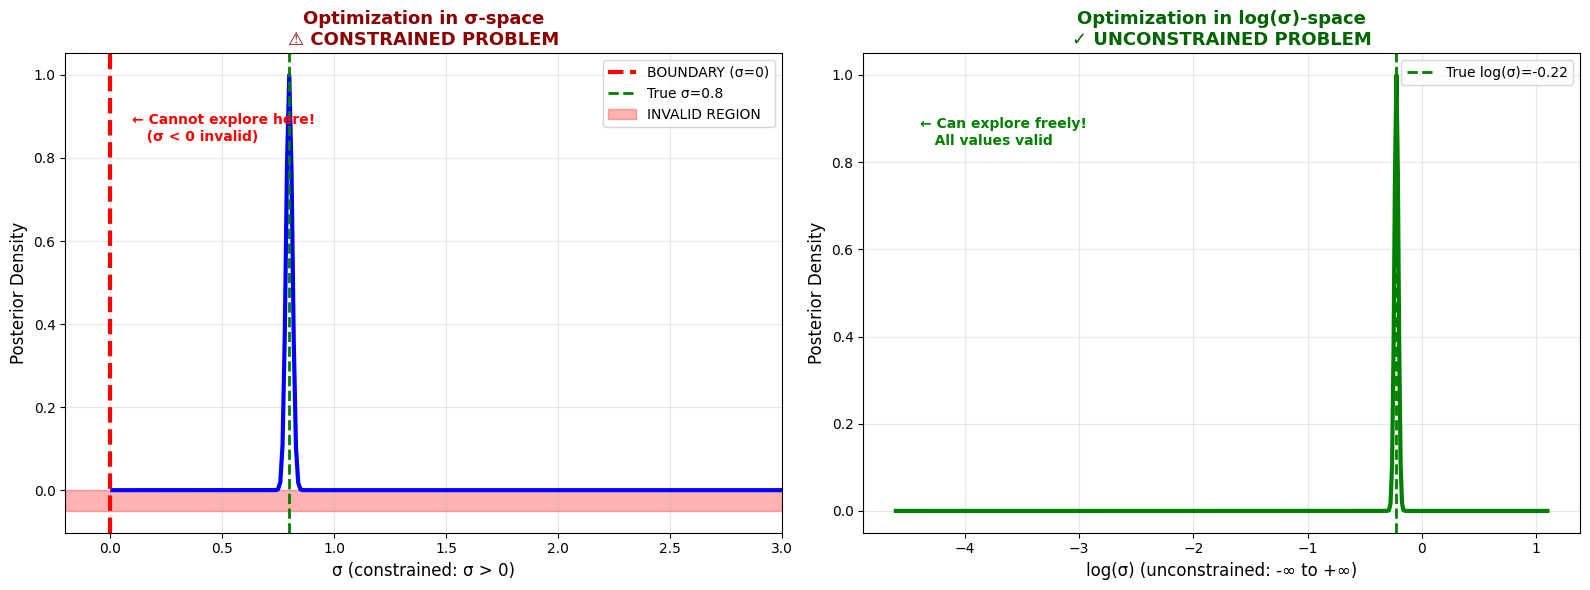

Why Log-Space is Better for Optimization:

In σ-space (CONSTRAINED):
  ❌ Hard boundary at σ = 0
  ❌ Gradient is undefined at boundary
  ❌ Optimizer must respect constraint (slower, harder)
  ❌ Can't explore negative values (even to compute gradient)
  ❌ Special constrained optimization algorithms needed

In log(σ)-space (UNCONSTRAINED):
  ✓ No boundaries! Can explore entire real line
  ✓ Gradient defined everywhere
  ✓ Standard optimization algorithms work
  ✓ When log(σ) = -∞, that means σ = 0 (handled naturally)
  ✓ When log(σ) < 0, that means 0 < σ < 1 (perfectly valid!)

The Transformation Magic:
  log(σ) = -∞  →  σ = 0
  log(σ) = -1  →  σ = 0.368
  log(σ) =  0  →  σ = 1
  log(σ) = +1  →  σ = 2.718
  log(σ) = +∞  →  σ = ∞

✓ The entire range (0, ∞) maps to (-∞, ∞)
✓ No constraints needed!


In [43]:
# Visualize the optimization landscape in both spaces

# Simple example: posterior of σ given some data
# True σ = 0.8 (our fitted value from M5.1)
true_sigma = 0.8

# Create a grid of sigma values
sigma_grid = np.linspace(0.01, 3, 300)  # Avoid exact 0
log_sigma_grid = np.log(sigma_grid)

# Compute log posterior for each sigma (simplified example)
# log p(σ | D) ∝ log p(D | σ) + log p(σ) + log(Jacobian)
def simplified_log_posterior(sigma):
    """Simplified: just prior + some likelihood term"""
    # Prior: Exponential(1)
    log_prior = stats.expon.logpdf(sigma, scale=1)
    
    # Simplified likelihood (pretend we observed some variance)
    # In reality this would be sum of normal log pdfs
    log_lik = -50 * ((sigma - true_sigma)**2) / (2 * 0.1**2)  # Gaussian-like around true value
    
    return log_lik + log_prior

# Compute in σ-space
log_post_sigma_space = np.array([simplified_log_posterior(s) for s in sigma_grid])

# Compute in log(σ)-space (with Jacobian!)
log_post_log_space = np.array([simplified_log_posterior(np.exp(ls)) + ls for ls in log_sigma_grid])

# Normalize for visualization
log_post_sigma_space -= log_post_sigma_space.max()
log_post_log_space -= log_post_log_space.max()

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimization in σ-space (CONSTRAINED)
ax = axes[0]
ax.plot(sigma_grid, np.exp(log_post_sigma_space), 'b-', linewidth=3)
ax.axvline(0, color='red', linewidth=3, label='BOUNDARY (σ=0)', linestyle='--')
ax.axvline(true_sigma, color='green', linewidth=2, label=f'True σ={true_sigma}', linestyle='--')
ax.axhspan(-0.05, 0, alpha=0.3, color='red', label='INVALID REGION')
ax.set_xlabel('σ (constrained: σ > 0)', fontsize=12)
ax.set_ylabel('Posterior Density', fontsize=12)
ax.set_title('Optimization in σ-space\n⚠️ CONSTRAINED PROBLEM', 
             fontsize=13, fontweight='bold', color='darkred')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.2, 3)
ax.text(0.1, ax.get_ylim()[1]*0.8, '← Cannot explore here!\n   (σ < 0 invalid)', 
        fontsize=10, color='red', fontweight='bold')

# Plot 2: Optimization in log(σ)-space (UNCONSTRAINED)
ax = axes[1]
ax.plot(log_sigma_grid, np.exp(log_post_log_space), 'g-', linewidth=3)
ax.axvline(np.log(true_sigma), color='green', linewidth=2, 
           label=f'True log(σ)={np.log(true_sigma):.2f}', linestyle='--')
ax.set_xlabel('log(σ) (unconstrained: -∞ to +∞)', fontsize=12)
ax.set_ylabel('Posterior Density', fontsize=12)
ax.set_title('Optimization in log(σ)-space\n✓ UNCONSTRAINED PROBLEM', 
             fontsize=13, fontweight='bold', color='darkgreen')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.text(ax.get_xlim()[0] + 0.5, ax.get_ylim()[1]*0.8, 
        '← Can explore freely!\n   All values valid', 
        fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print("Why Log-Space is Better for Optimization:")
print("="*70)
print("\nIn σ-space (CONSTRAINED):")
print("  ❌ Hard boundary at σ = 0")
print("  ❌ Gradient is undefined at boundary")
print("  ❌ Optimizer must respect constraint (slower, harder)")
print("  ❌ Can't explore negative values (even to compute gradient)")
print("  ❌ Special constrained optimization algorithms needed")

print("\nIn log(σ)-space (UNCONSTRAINED):")
print("  ✓ No boundaries! Can explore entire real line")
print("  ✓ Gradient defined everywhere")
print("  ✓ Standard optimization algorithms work")
print("  ✓ When log(σ) = -∞, that means σ = 0 (handled naturally)")
print("  ✓ When log(σ) < 0, that means 0 < σ < 1 (perfectly valid!)")

print("\nThe Transformation Magic:")
print("  log(σ) = -∞  →  σ = 0")
print("  log(σ) = -1  →  σ = 0.368")
print("  log(σ) =  0  →  σ = 1")
print("  log(σ) = +1  →  σ = 2.718")
print("  log(σ) = +∞  →  σ = ∞")
print("\n✓ The entire range (0, ∞) maps to (-∞, ∞)")
print("✓ No constraints needed!")

### Limitation of Our QUAP Implementation

**Important Note:** Our simple QUAP returns **log(σ)**, not **σ** directly.

In Statistical Rethinking's R package, `quap()` automatically:
1. Optimizes in log-space (internal)
2. Reports results in original scale (external)

Our implementation shows the "raw" optimized parameters. To get σ statistics, we need to transform manually.

In [44]:
# How to get proper posterior statistics for σ

print("Comparing: What we have vs What we want")
print("="*70)

# What our QUAP gives us (log-scale)
print("\n1. What QUAP Returns (log-scale):")
print("-" * 50)
log_sigma_mean = m51.coef()['log_sigma']
log_sigma_std = m51.vcov().loc['log_sigma', 'log_sigma']**0.5
print(f"   log(σ) ~ Normal({log_sigma_mean:.4f}, {log_sigma_std:.4f}²)")
print(f"   This is the INTERNAL representation")

# Transform to get σ statistics
print("\n2. What We Want (original scale):")
print("-" * 50)

# Sample from posterior to get proper statistics
post_samples = m51.sample(n=10000, seed=42)
sigma_samples = np.exp(post_samples['log_sigma'].values)

sigma_mean = sigma_samples.mean()
sigma_std = sigma_samples.std()
sigma_quantiles = np.percentile(sigma_samples, [5.5, 50, 94.5])

print(f"   σ statistics (from samples):")
print(f"     Mean:   {sigma_mean:.4f}")
print(f"     Median: {sigma_quantiles[1]:.4f}")
print(f"     Std:    {sigma_std:.4f}")
print(f"     89% CI: [{sigma_quantiles[0]:.4f}, {sigma_quantiles[2]:.4f}]")

# Compare with what Statistical Rethinking would show
print("\n3. What Statistical Rethinking (R) Would Show:")
print("-" * 50)
print("   precis(m5.1):")
print("          mean    sd   5.5%  94.5%")
print(f"   sigma {sigma_mean:.2f}  {sigma_std:.2f}  {sigma_quantiles[0]:.2f}   {sigma_quantiles[2]:.2f}")
print("   (Reported in ORIGINAL scale, not log-scale)")

print("\n" + "="*70)
print("Summary:")
print("="*70)
print("✓ Statistical Rethinking automatically transforms constrained parameters")
print("✓ Our implementation requires manual transformation via sampling")
print("✓ Both are mathematically correct, ours is just less convenient")
print("\nBest practice: Always sample and report statistics for σ, not log(σ)!")

Comparing: What we have vs What we want

1. What QUAP Returns (log-scale):
--------------------------------------------------
   log(σ) ~ Normal(-0.2179, 0.0999²)
   This is the INTERNAL representation

2. What We Want (original scale):
--------------------------------------------------
   σ statistics (from samples):
     Mean:   0.8079
     Median: 0.8040
     Std:    0.0810
     89% CI: [0.6842, 0.9432]

3. What Statistical Rethinking (R) Would Show:
--------------------------------------------------
   precis(m5.1):
          mean    sd   5.5%  94.5%
   sigma 0.81  0.08  0.68   0.94
   (Reported in ORIGINAL scale, not log-scale)

Summary:
✓ Statistical Rethinking automatically transforms constrained parameters
✓ Our implementation requires manual transformation via sampling
✓ Both are mathematically correct, ours is just less convenient

Best practice: Always sample and report statistics for σ, not log(σ)!


In [45]:
# Demonstrating Parameter Transformations

# Re-fit M5.1 (fresh start)
print("Step 1: Fit the model (M5.1 already fitted above)")
print("=" * 70)
print(f"Model: {m51}")
print("\nCurrent parameter names (internal, log-scale):")
print(f"  {m51._original_param_names}")

# Register transformation
print("\n\nStep 2: Register transformation for log_sigma → sigma")
print("=" * 70)
m51.transform_param('log_sigma', new_name='sigma', transform=np.exp)

# Now all methods automatically show transformed parameters!
print("\n\nStep 3: All QUAP methods now show σ (not log(σ))")
print("=" * 70)

# coef() - now shows sigma
print("\n📊 coef():")
print("-" * 50)
coefs_transformed = m51.coef()
for name, val in coefs_transformed.items():
    print(f"  {name:10s} = {val:.4f}")

# summary() - now shows sigma with correct statistics
print("\n\n📊 summary():")
print("-" * 50)
summary_df = m51.summary()

# sample() - now returns sigma column
print("\n\n📊 sample():")
print("-" * 50)
samples_transformed = m51.sample(n=5, seed=42)
print(samples_transformed)
print(f"\n✓ Note: Column is 'sigma', not 'log_sigma'!")

# vcov() and corrcoef() also work
print("\n\n📊 vcov() - Variance-Covariance Matrix:")
print("-" * 50)
print(m51.vcov())

print("\n\n📊 corrcoef() - Correlation Matrix:")
print("-" * 50)
print(m51.corrcoef())

# Compare with manual transformation (old way)
print("\n\n" + "=" * 70)
print("Comparison: Old Way vs New Way")
print("=" * 70)

# Manual way (what we did before)
print("\nOld Way (manual sampling + transform):")
print("-" * 50)
# We'd have to fit without transform, then sample and transform
m51_no_transform = quap(neg_log_posterior_m51, initial_params_m51, param_names_m51)
samples_manual = m51_no_transform.sample(n=10000, seed=42)
sigma_manual = np.exp(samples_manual['log_sigma'])
print(f"  σ mean: {sigma_manual.mean():.4f}")
print(f"  σ std:  {sigma_manual.std():.4f}")
print(f"  → Required manual sampling + np.exp()")

# New way (with transformation)
print("\nNew Way (with transform_param):")
print("-" * 50)
sigma_new_mean = coefs_transformed['sigma']
sigma_new_std = summary_df.loc['sigma', 'std']
print(f"  σ mean: {sigma_new_mean:.4f}")
print(f"  σ std:  {sigma_new_std:.4f}")
print(f"  → Automatic! All methods just work!")

print("\n\n✓ Results match!")
print("✓ But new way is much more convenient!")
print("✓ Matches Statistical Rethinking's interface!")

Step 1: Fit the model (M5.1 already fitted above)
Model: QuapResult(3 parameters: alpha, beta_A, log_sigma)

Current parameter names (internal, log-scale):
  ['alpha', 'beta_A', 'log_sigma']


Step 2: Register transformation for log_sigma → sigma
✓ Registered transformation: log_sigma -> sigma


Step 3: All QUAP methods now show σ (not log(σ))

📊 coef():
--------------------------------------------------
  alpha      = -0.0002
  beta_A     = -0.5684
  sigma      = 0.8079


📊 summary():
--------------------------------------------------
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0199 seconds
Log posterior at MAP: -61.15

          mean    std  89%_lower  89%_upper
alpha  -0.0002 0.0982    -0.1578     0.1555
beta_A -0.5684 0.1112    -0.7459    -0.3884
sigma   0.8079 0.0810     0.6842     0.9432


📊 sample():
--------------------------------------------------
      alpha    beta_A     sigma
0 -0.064032 -0.516810  0.825028
1  0.023147 -0.407181  0.853998
2  0.046415 -0.379165  0.

### Solution: Parameter Transformations in QUAP

**Good news!** Our QUAP now supports parameter transformations.

We can tell QUAP to automatically transform `log_sigma` → `sigma` so all methods work directly with σ.

**The Workflow:**
1. Fit model (QUAP optimizes in log-space internally)
2. Register transformation: `m51.transform_param('log_sigma', 'sigma', np.exp)`
3. All methods now return σ, not log(σ)!

Let's see it in action.

### Step 1: Prior Predictive Simulation

**Before seeing data**, what relationships do our priors imply?

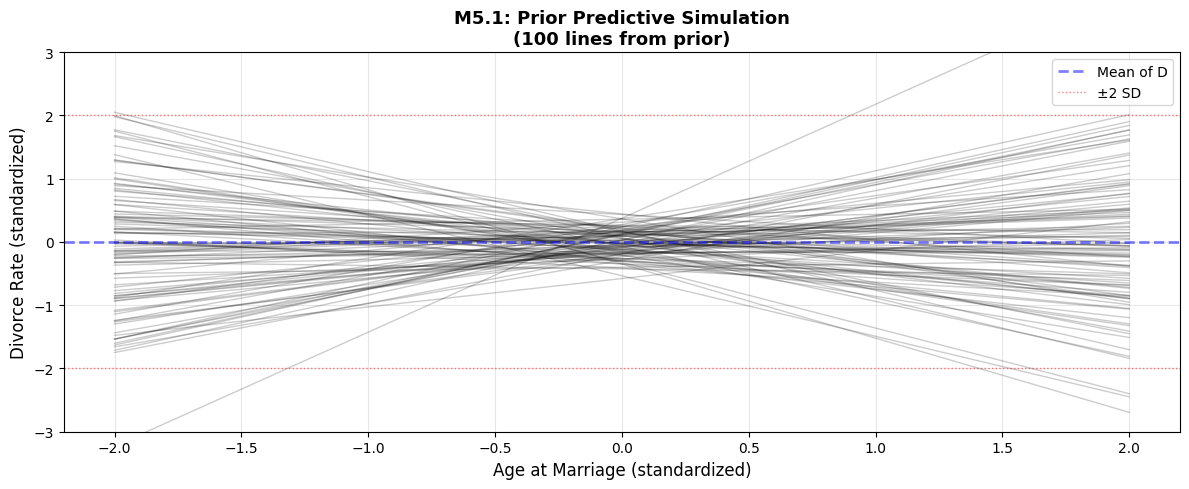

Prior Check:
• Lines are reasonable (mostly within ±2 SD)
• Some positive, some negative slopes (no strong bias)
• Weakly informative - allows data to dominate


In [46]:
# Prior predictive simulation for M5.1
n_prior_samples = 100
A_seq = np.linspace(-2, 2, 50)  # Range of standardized age values

# Sample from priors
alpha_prior = np.random.normal(0, 0.2, n_prior_samples)
beta_A_prior = np.random.normal(0, 0.5, n_prior_samples)
sigma_prior = np.random.exponential(1, n_prior_samples)

# Generate prior predictions
plt.figure(figsize=(12, 5))

for i in range(n_prior_samples):
    mu = alpha_prior[i] + beta_A_prior[i] * A_seq
    plt.plot(A_seq, mu, 'k-', alpha=0.2, linewidth=1)

plt.axhline(0, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Mean of D')
plt.axhline(-2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(2, color='red', linestyle=':', linewidth=1, alpha=0.5, label='±2 SD')
plt.xlabel('Age at Marriage (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.1: Prior Predictive Simulation\n(100 lines from prior)', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

print("Prior Check:")
print("• Lines are reasonable (mostly within ±2 SD)")
print("• Some positive, some negative slopes (no strong bias)")
print("• Weakly informative - allows data to dominate")

### Step 2: Fit Model M5.1 with Quap

In [47]:
def neg_log_posterior_m51(params):
    """
    M5.1: D ~ α + βA·A
    
    Parameters: [alpha, beta_A, log_sigma]
    """
    alpha = params[0]
    beta_A = params[1]
    log_sigma = params[2]
    sigma = np.exp(log_sigma)
    
    # Linear model
    mu = alpha + beta_A * A
    
    # Likelihood: D ~ Normal(mu, sigma)
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    
    # Priors
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=0.2)
    log_prior_beta_A = stats.norm.logpdf(beta_A, loc=0, scale=0.5)
    log_prior_log_sigma = stats.expon.logpdf(sigma, scale=1)  # σ ~ Exponential(1)
    
    # Jacobian for log transform
    jacobian = log_sigma
    
    log_posterior = log_lik + log_prior_alpha + log_prior_beta_A + log_prior_log_sigma + jacobian
    
    return -log_posterior

# Initial values
initial_params_m51 = [0.0, 0.0, np.log(1.0)]
param_names_m51 = ['alpha', 'beta_A', 'log_sigma']

# Fit
print("Fitting M5.1: Divorce ~ Age...")
m51 = quap(neg_log_posterior_m51, initial_params_m51, param_names_m51)
print("✓ Model fitted")

# Transform log_sigma to sigma for user-friendly output
m51.transform_param('log_sigma', 'sigma', np.exp)
print("✓ Transformed log_sigma → sigma\n")

# Summary
m51.summary()

Fitting M5.1: Divorce ~ Age...
✓ Model fitted
✓ Registered transformation: log_sigma -> sigma
✓ Transformed log_sigma → sigma

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0166 seconds
Log posterior at MAP: -61.15

          mean    std  89%_lower  89%_upper
alpha  -0.0002 0.0982    -0.1578     0.1555
beta_A -0.5673 0.1112    -0.7474    -0.3898
sigma   0.8085 0.0812     0.6856     0.9452


,mean,std,89%_lower,89%_upper
alpha,-0.000195,0.098163,-0.157834,0.155480
beta_A,-0.567297,0.111234,-0.747366,-0.389830
sigma,0.808542,0.081239,0.685645,0.945207


### Step 3: Interpret M5.1 Results

In [48]:
# Extract coefficients
coef_m51 = m51.coef()
sigma_m51 = coef_m51['sigma']  # Now directly available!

print("M5.1 Interpretation:")
print("="*70)
print(f"α = {coef_m51['alpha']:.3f}")
print("  → Mean divorce rate when A=0 (average age)")
print(f"\nβA = {coef_m51['beta_A']:.3f}")
print("  → Change in divorce per 1 SD increase in age")
if coef_m51['beta_A'] < 0:
    print("  → NEGATIVE: Older marriage age → Lower divorce")
else:
    print("  → POSITIVE: Older marriage age → Higher divorce")
print(f"\nσ = {sigma_m51:.3f}")
print("  → Residual variation after accounting for age")

M5.1 Interpretation:
α = -0.000
  → Mean divorce rate when A=0 (average age)

βA = -0.567
  → Change in divorce per 1 SD increase in age
  → NEGATIVE: Older marriage age → Lower divorce

σ = 0.809
  → Residual variation after accounting for age


### Step 4: Posterior Prediction Plot

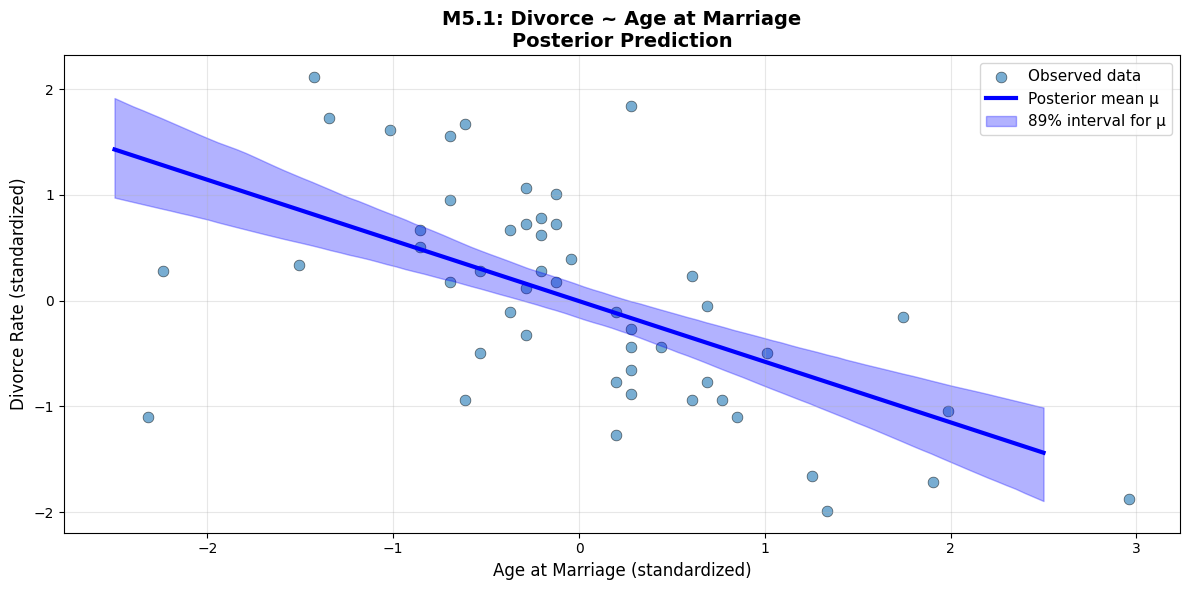

✓ Strong negative relationship: Older age → Lower divorce


In [49]:
# Generate predictions
A_seq = np.linspace(-2.5, 2.5, 100)
post_m51 = m51.sample(n=1000, seed=42)

# Compute μ for each sample
mu_samples = post_m51['alpha'].values[:, None] + post_m51['beta_A'].values[:, None] * A_seq[None, :]

# Summary statistics
mu_mean = mu_samples.mean(axis=0)
mu_lower = np.percentile(mu_samples, 5.5, axis=0)
mu_upper = np.percentile(mu_samples, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))

# Data points
plt.scatter(A, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, label='Observed data')

# Mean line
plt.plot(A_seq, mu_mean, 'b-', linewidth=3, label='Posterior mean μ')

# Uncertainty band
plt.fill_between(A_seq, mu_lower, mu_upper, alpha=0.3, color='blue', label='89% interval for μ')

plt.xlabel('Age at Marriage (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.1: Divorce ~ Age at Marriage\nPosterior Prediction', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Strong negative relationship: Older age → Lower divorce")

---

## Model M5.2: Divorce ~ Marriage Rate

### Model Specification

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_M \cdot M_i$$

**Same priors as M5.1:**
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_M \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

### Step 1: Prior Predictive Check M5.2

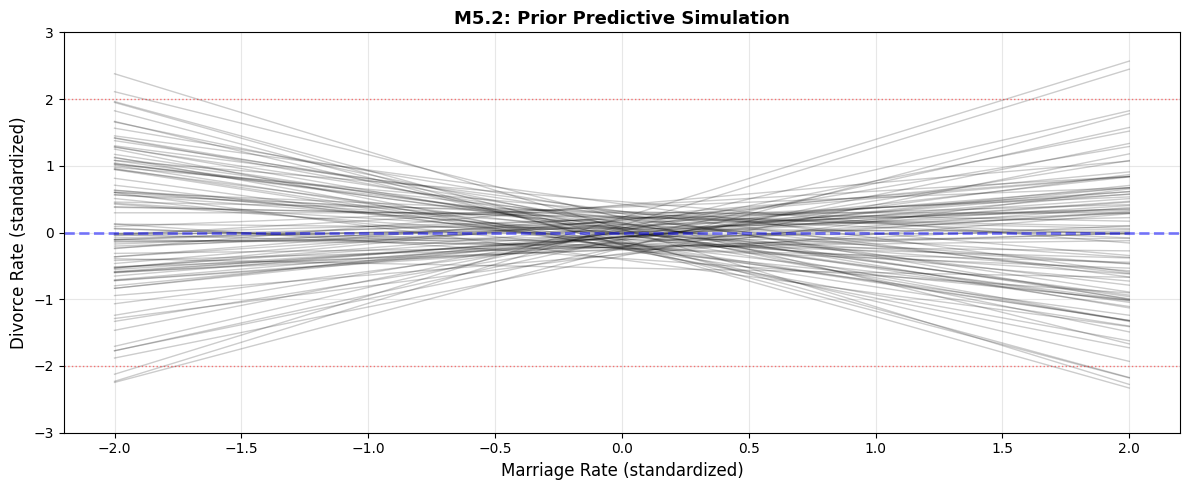

In [50]:
# Prior predictive (same logic as M5.1)
M_seq = np.linspace(-2, 2, 50)

alpha_prior = np.random.normal(0, 0.2, n_prior_samples)
beta_M_prior = np.random.normal(0, 0.5, n_prior_samples)

plt.figure(figsize=(12, 5))

for i in range(n_prior_samples):
    mu = alpha_prior[i] + beta_M_prior[i] * M_seq
    plt.plot(M_seq, mu, 'k-', alpha=0.2, linewidth=1)

plt.axhline(0, color='blue', linestyle='--', linewidth=2, alpha=0.5)
plt.axhline(-2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(2, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.xlabel('Marriage Rate (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.2: Prior Predictive Simulation', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

### Step 2: Fit Model M5.2

In [51]:
def neg_log_posterior_m52(params):
    """
    M5.2: D ~ α + βM·M
    
    Parameters: [alpha, beta_M, log_sigma]
    """
    alpha = params[0]
    beta_M = params[1]
    log_sigma = params[2]
    sigma = np.exp(log_sigma)
    
    # Linear model
    mu = alpha + beta_M * M
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    
    # Priors
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=0.2)
    log_prior_beta_M = stats.norm.logpdf(beta_M, loc=0, scale=0.5)
    log_prior_log_sigma = stats.expon.logpdf(sigma, scale=1)
    
    # Jacobian
    jacobian = log_sigma
    
    log_posterior = log_lik + log_prior_alpha + log_prior_beta_M + log_prior_log_sigma + jacobian
    
    return -log_posterior

# Fit
initial_params_m52 = [0.0, 0.0, np.log(1.0)]
param_names_m52 = ['alpha', 'beta_M', 'log_sigma']

print("Fitting M5.2: Divorce ~ Marriage Rate...")
m52 = quap(neg_log_posterior_m52, initial_params_m52, param_names_m52)
print("✓ Model fitted")

# Transform log_sigma to sigma
m52.transform_param('log_sigma', 'sigma', np.exp)
print("✓ Transformed log_sigma → sigma\n")

m52.summary()

Fitting M5.2: Divorce ~ Marriage Rate...
✓ Model fitted
✓ Registered transformation: log_sigma -> sigma
✓ Transformed log_sigma → sigma

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0106 seconds
Log posterior at MAP: -67.99

         mean    std  89%_lower  89%_upper
alpha  0.0003 0.1097    -0.1716     0.1749
beta_M 0.3504 0.1277     0.1441     0.5528
sigma  0.9332 0.0924     0.7946     1.0882


,mean,std,89%_lower,89%_upper
alpha,0.000293,0.109696,-0.171577,0.174858
beta_M,0.350356,0.127691,0.144081,0.552814
sigma,0.933191,0.092412,0.794603,1.088159


### Step 3: Interpret M5.2 Results

In [52]:
coef_m52 = m52.coef()
sigma_m52 = coef_m52['sigma']  # Now directly available!

print("M5.2 Interpretation:")
print("="*70)
print(f"α = {coef_m52['alpha']:.3f}")
print("  → Mean divorce when M=0 (average marriage rate)")
print(f"\nβM = {coef_m52['beta_M']:.3f}")
print("  → Change in divorce per 1 SD increase in marriage rate")
if coef_m52['beta_M'] > 0:
    print("  → POSITIVE: Higher marriage rate → Higher divorce")
else:
    print("  → NEGATIVE: Higher marriage rate → Lower divorce")
print(f"\nσ = {sigma_m52:.3f}")
print("  → Residual variation")

M5.2 Interpretation:
α = 0.000
  → Mean divorce when M=0 (average marriage rate)

βM = 0.350
  → Change in divorce per 1 SD increase in marriage rate
  → POSITIVE: Higher marriage rate → Higher divorce

σ = 0.933
  → Residual variation


### Step 4: Posterior Prediction Plot M5.2

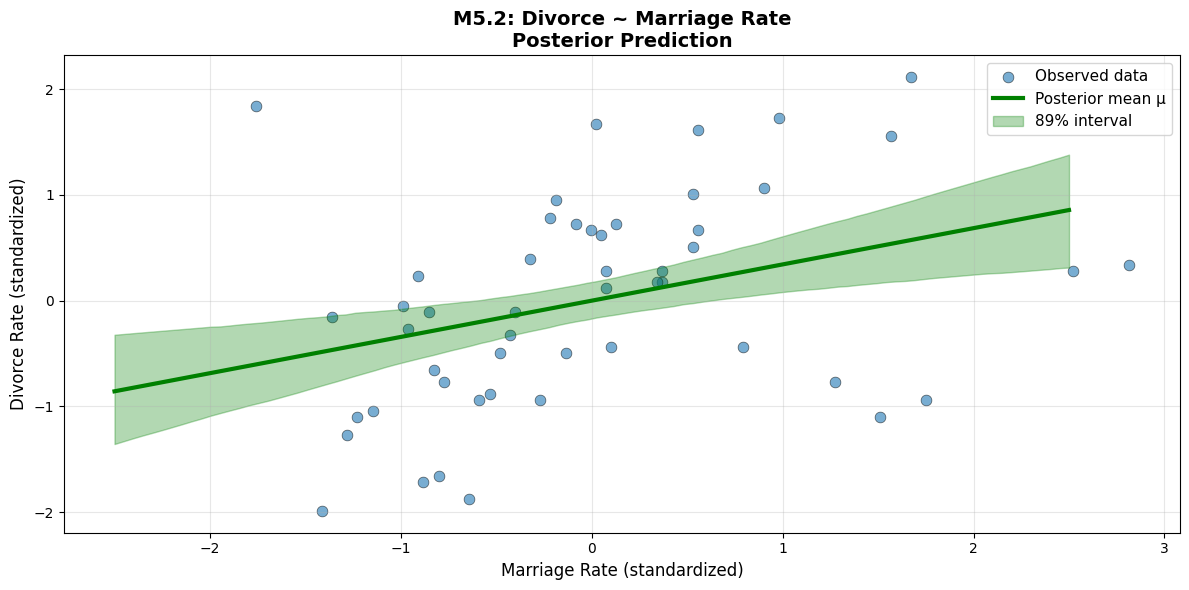

✓ Positive relationship: Higher marriage rate → Higher divorce


In [53]:
# Generate predictions
M_seq = np.linspace(-2.5, 2.5, 100)
post_m52 = m52.sample(n=1000, seed=42)

mu_samples_m52 = post_m52['alpha'].values[:, None] + post_m52['beta_M'].values[:, None] * M_seq[None, :]

mu_mean_m52 = mu_samples_m52.mean(axis=0)
mu_lower_m52 = np.percentile(mu_samples_m52, 5.5, axis=0)
mu_upper_m52 = np.percentile(mu_samples_m52, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))

plt.scatter(M, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, label='Observed data')
plt.plot(M_seq, mu_mean_m52, 'g-', linewidth=3, label='Posterior mean μ')
plt.fill_between(M_seq, mu_lower_m52, mu_upper_m52, alpha=0.3, color='green', label='89% interval')

plt.xlabel('Marriage Rate (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('M5.2: Divorce ~ Marriage Rate\nPosterior Prediction', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Positive relationship: Higher marriage rate → Higher divorce")

---

## Compare M5.1 and M5.2

Let's compare the two models side-by-side.

In [54]:
# Comparison table
comparison = pd.DataFrame({
    'M5.1 (Age)': [
        f"{coef_m51['alpha']:.3f}",
        f"{coef_m51['beta_A']:.3f}",
        "—",
        f"{sigma_m51:.3f}"
    ],
    'M5.2 (Marriage)': [
        f"{coef_m52['alpha']:.3f}",
        "—",
        f"{coef_m52['beta_M']:.3f}",
        f"{sigma_m52:.3f}"
    ]
}, index=['α', 'βA', 'βM', 'σ'])

print("Model Comparison:")
print("="*70)
print(comparison)
print("\nObservations:")
print("• Both predictors show relationships with divorce")
print("• Age: Strong NEGATIVE effect")
print("• Marriage rate: POSITIVE effect")
print("• But are these real or confounded?")
print("• Next: Multiple regression will reveal the truth!")

Model Comparison:
   M5.1 (Age) M5.2 (Marriage)
α      -0.000           0.000
βA     -0.567               —
βM          —           0.350
σ       0.809           0.933

Observations:
• Both predictors show relationships with divorce
• Age: Strong NEGATIVE effect
• Marriage rate: POSITIVE effect
• But are these real or confounded?
• Next: Multiple regression will reveal the truth!


---

## Making Predictions with Standardized Models

**Critical Question:** When we fit models on standardized data, how do we make predictions for new observations?

### The Workflow

1. **Training**: Standardize using training data statistics (save mean & std)
2. **Prediction**: Standardize new data using **training statistics**
3. **Un-standardize**: Convert predictions back to original scale

**Important:** Always use training data statistics, never re-compute from new data!

---

In [55]:
# Example: Predict divorce rate for hypothetical new states

# Save training data statistics (CRITICAL!)
mean_age_train = age.mean()
std_age_train = age.std()
mean_divorce_train = divorce.mean()
std_divorce_train = divorce.std()

print("Training Data Statistics (saved for future predictions):")
print("="*70)
print(f"Age:     mean = {mean_age_train:.2f} years, std = {std_age_train:.2f} years")
print(f"Divorce: mean = {mean_divorce_train:.2f} per 1000, std = {std_divorce_train:.2f} per 1000")
print("="*70)

# Scenario 1: Late marriage (age = 28 years)
age_new1 = 28.0
print(f"\n\nScenario 1: Predict divorce for state with marriage age = {age_new1} years")
print("-"*70)

# Step 1: Standardize using TRAINING statistics
age_new1_std = (age_new1 - mean_age_train) / std_age_train
print(f"Step 1 - Standardize: ({age_new1} - {mean_age_train:.2f}) / {std_age_train:.2f} = {age_new1_std:.3f}")

# Step 2: Get posterior samples
post = m51.sample(n=1000, seed=42)

# Step 3: Predict in standardized units
mu_std_samples = post['alpha'].values + post['beta_A'].values * age_new1_std
mu_std_mean = mu_std_samples.mean()
mu_std_lower = np.percentile(mu_std_samples, 5.5)
mu_std_upper = np.percentile(mu_std_samples, 94.5)

print(f"Step 2 - Predict (standardized): μ_std = {mu_std_mean:.3f} [{mu_std_lower:.3f}, {mu_std_upper:.3f}]")

# Step 4: Un-standardize to get original scale
divorce_pred_mean = mu_std_mean * std_divorce_train + mean_divorce_train
divorce_pred_lower = mu_std_lower * std_divorce_train + mean_divorce_train
divorce_pred_upper = mu_std_upper * std_divorce_train + mean_divorce_train

print(f"Step 3 - Un-standardize: {mu_std_mean:.3f} * {std_divorce_train:.2f} + {mean_divorce_train:.2f}")
print(f"         → Predicted divorce = {divorce_pred_mean:.2f} per 1000")
print(f"         → 89% interval: [{divorce_pred_lower:.2f}, {divorce_pred_upper:.2f}]")

# Scenario 2: Early marriage (age = 24 years)
age_new2 = 24.0
print(f"\n\nScenario 2: Predict divorce for state with marriage age = {age_new2} years")
print("-"*70)

age_new2_std = (age_new2 - mean_age_train) / std_age_train
mu_std_samples2 = post['alpha'].values + post['beta_A'].values * age_new2_std
mu_std_mean2 = mu_std_samples2.mean()

divorce_pred_mean2 = mu_std_mean2 * std_divorce_train + mean_divorce_train

print(f"Standardized age: {age_new2_std:.3f}")
print(f"Predicted divorce = {divorce_pred_mean2:.2f} per 1000")
print(f"\n✓ Early marriage (24y) → Higher divorce ({divorce_pred_mean2:.2f})")
print(f"✓ Late marriage (28y) → Lower divorce ({divorce_pred_mean:.2f})")

Training Data Statistics (saved for future predictions):
Age:     mean = 26.05 years, std = 1.23 years
Divorce: mean = 9.69 per 1000, std = 1.80 per 1000


Scenario 1: Predict divorce for state with marriage age = 28.0 years
----------------------------------------------------------------------
Step 1 - Standardize: (28.0 - 26.05) / 1.23 = 1.581
Step 2 - Predict (standardized): μ_std = -0.911 [-1.214, -0.621]
Step 3 - Un-standardize: -0.911 * 1.80 + 9.69
         → Predicted divorce = 8.05 per 1000
         → 89% interval: [7.50, 8.57]


Scenario 2: Predict divorce for state with marriage age = 24.0 years
----------------------------------------------------------------------
Standardized age: -1.668
Predicted divorce = 11.40 per 1000

✓ Early marriage (24y) → Higher divorce (11.40)
✓ Late marriage (28y) → Lower divorce (8.05)


### Key Takeaways

**The Prediction Pipeline:**
1. Save training statistics (mean, std) when you fit the model
2. Standardize new data using **training statistics** (never re-compute!)
3. Get predictions from posterior (result is in standardized units)
4. Un-standardize predictions back to original units

**Why this matters:**
- The posterior is in standardized scale (because we trained on standardized data)
- Must transform new inputs the same way as training data
- Must transform predictions back to be interpretable

**Common mistake:** Re-computing mean/std from new data → Wrong! Always use training statistics.

---

---

## Summary

### M5.1: Divorce ~ Age
- **βA < 0**: Older marriage age associated with lower divorce
- Strong, clear relationship

### M5.2: Divorce ~ Marriage Rate
- **βM > 0**: Higher marriage rate associated with higher divorce
- Also appears significant

### The Question

**Both predictors appear to matter.** But:
- What happens when we include BOTH?
- Are they telling us different things?
- Or is one effect spurious (confounded)?

### Next Steps

**Notebook 3: Multiple Regression**
- Fit M5.3: D ~ A + M
- Compare coefficients across models
- Discover which effects are real vs confounded

**Spoiler:** One of these relationships will nearly disappear!

---